**Face Mask Detection using VGG16 Knowledge transfer method**

**Mounting drive for dataset access**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Mask_Unmask_dataset.zip"

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Input
from keras.activations import relu, softmax
from keras.models import Model

**Preparing dataset for model training**

In [ ]:
classes = os.listdir("/content/dataset")
# 0 for mask
# 1 for no mask

**Reading image data**

In [ ]:
pixel = []
label = []

for category in classes:
  imagepath = os.path.join("/content/dataset",category)
  images = os.listdir(imagepath)
  for image in images:
    # processing of images
    img = load_img(os.path.join(imagepath,image),target_size=(224,224))
    img = img_to_array(img)
    img = img / 255.0

    pixel.append(img)
    label.append(classes.index(category))
  
# onehot encoding the labels
label = to_categorical(label)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
pixel = np.array(pixel)
pixel = pixel.reshape(pixel.shape[0],224,224,3)
label = np.array(label)

**spliting of dataset for train and test**

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(pixel,label,test_size = 0.3, random_state = 101)

**Image Augmentation** 

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

**Model design**

In [ ]:
model = VGG16(include_top=False, weights='imagenet')
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
# making the VGG16 model part untrainable.

for layer in model.layers:
  layer.trainable = False

In [ ]:
# Combining the Model

# Defining the input layer
inputlayer = Input(shape =  (224,224,3))

# VGG16 model layer
vggmodel = model(inputlayer)

# Defining the outlayer or top layer for VGG16
outlayer = Flatten()(vggmodel)
outlayer = Dense(4096, activation="relu")(outlayer)
outlayer = Dense(512, activation="relu")(outlayer)
outlayer = Dense(2,activation="softmax")(outlayer)

# Combining the layers
clsmodel = Model(inputs = inputlayer, outputs = outlayer)
clsmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 119,577,922
Trainable params: 104,863,234
Non-trainable params: 14,714,688
_______________________________

**Training of model**

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
# compilie the model

opt = Adam(INIT_LR, decay = INIT_LR/EPOCHS)
clsmodel.compile(optimizer=opt, loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
# training of the model
History = clsmodel.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	epochs=EPOCHS,
	verbose=1)

Epoch 1/20
85/85 [==============================] - 35s 415ms/step - loss: 0.0393 - accuracy: 0.9859 - val_loss: 0.0246 - val_accuracy: 0.9922
Epoch 2/20
85/85 [==============================] - 35s 414ms/step - loss: 0.0273 - accuracy: 0.9907 - val_loss: 0.0294 - val_accuracy: 0.9913
Epoch 3/20
85/85 [==============================] - 35s 412ms/step - loss: 0.0326 - accuracy: 0.9863 - val_loss: 0.0270 - val_accuracy: 0.9922
Epoch 4/20
85/85 [==============================] - 35s 413ms/step - loss: 0.0292 - accuracy: 0.9889 - val_loss: 0.0295 - val_accuracy: 0.9922
Epoch 5/20
85/85 [==============================] - 35s 412ms/step - loss: 0.0320 - accuracy: 0.9896 - val_loss: 0.0588 - val_accuracy: 0.9749
Epoch 6/20
85/85 [==============================] - 35s 411ms/step - loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.0251 - val_accuracy: 0.9913
Epoch 7/20
85/85 [==============================] - 35s 413ms/step - loss: 0.0253 - accuracy: 0.9900 - val_loss: 0.0370 - val_accuracy: 0.9870

In [ ]:
# Evaluation of the model
predictions = clsmodel.predict(testX)
predictions = predictions.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(testY.argmax(axis=1), predictions,target_names=classes))

              precision    recall  f1-score   support

   with_mask       0.99      0.98      0.99       570
without_mask       0.98      0.99      0.99       584

    accuracy                           0.99      1154
   macro avg       0.99      0.99      0.99      1154
weighted avg       0.99      0.99      0.99      1154



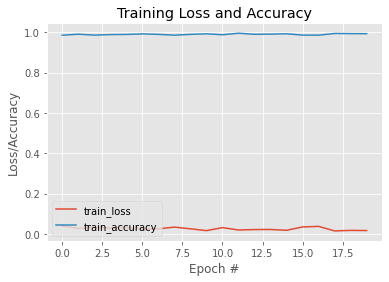

In [ ]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/Face_mask_detection_project/maskclassifiermodelplot.png")

In [ ]:
# Saving the model
clsmodel.save("/content/drive/My Drive/Face_mask_detection_project/maskclassifiermodel.h5")